<a href="https://colab.research.google.com/github/gmfv/Prediccion_Temperatura_IA/blob/main/AlgoritmoGenetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap

     |████████████████████████████████| 163kB 7.1MB/s 


In [ ]:
!pip install bitstring

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1120)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')

pred = 2 #Por ser 24 horas del dia
#df = load_dataset('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')
df["Dia"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[2]))
df["Mes"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[1]))
df["Año"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[0]))
df["Hora"]=df['date'].apply(lambda x: int(x.split()[1].split(':')[0]))
df["temp_t1"] = df["Temperatura Asuncion"].shift(periods=-pred)
df["Year_t1"] = df["Año"].shift(periods=-pred)
df["Hour_t1"] = df["Hora"].shift(periods=-pred)
df["Month_t1"] = df["Mes"].shift(periods=-pred)
df["Weekday_t1"] = df["Dia"].shift(periods=-pred)
df = df.dropna()
#df.drop(columns='date',inplace=True)
df=df.set_index("date")
df=df[df['Hora']%2 == 0]
#data["Temperatura Asuncion"]
df

,Temperatura Asuncion,Dia,Mes,Año,Hora,temp_t1,Year_t1,Hour_t1,Month_t1,Weekday_t1
date,,,,,,,,,,
2009-01-08 00:00:00,26.769231,8,1,2009,0,24.215385,2009.0,2.0,1.0,8.0
2009-01-08 02:00:00,24.215385,8,1,2009,2,23.007692,2009.0,4.0,1.0,8.0
2009-01-08 04:00:00,23.007692,8,1,2009,4,21.738462,2009.0,6.0,1.0,8.0
2009-01-08 06:00:00,21.738462,8,1,2009,6,20.692308,2009.0,8.0,1.0,8.0
2009-01-08 08:00:00,20.692308,8,1,2009,8,24.053846,2009.0,10.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-30 12:00:00,29.900000,30,12,2017,12,31.500000,2017.0,14.0,12.0,30.0
2017-12-30 14:00:00,31.500000,30,12,2017,14,32.900000,2017.0,16.0,12.0,30.0
2017-12-30 16:00:00,32.900000,30,12,2017,16,34.000000,2017.0,18.0,12.0,30.0


In [ ]:
data1 = df["Temperatura Asuncion"]
data2 = df["temp_t1"]
data1 = np.reshape(np.array(df['Temperatura Asuncion']),(len(df['Temperatura Asuncion']),1))
data2 = np.reshape(np.array(df['temp_t1']),(len(df['temp_t1']),1))

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
#df = scaler.fit_transform(df['Temperatura Asuncion'])
data1 = scaler.fit_transform(data1)

In [ ]:
df["Temperatura Asuncion"]=data1

In [ ]:
train_data = df[['Temperatura Asuncion']].values[0:round(len(df)*0.8)]
test_data = df[['Temperatura Asuncion']].values[round(len(df)*0.8)+1:-1]

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 0 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 0, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=5, batch_size=10, callbacks=[callback], verbose=0)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    RMSE.append(rmse)
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [ ]:
population_size = 10
num_generations = 10
gene_length = 10
RMSE = []
creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
#toolbox.register('select', tools.selRoulette)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
#population = lista de individuos; cxpb probabilidad de aparear dos individuos; mutpb probabilidad de mutar un individuo;  ngen numero de generaciones; 
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1,
                        ngen = num_generations, verbose = False)


Window Size:  36 , Num of Units:  2
Validation RMSE:  0.05313822552199009 


Window Size:  56 , Num of Units:  8
Validation RMSE:  0.04464647610404876 


Window Size:  60 , Num of Units:  9
Validation RMSE:  0.040950533746103135 


Window Size:  49 , Num of Units:  9
Validation RMSE:  0.03927372383939271 


Window Size:  34 , Num of Units:  9
Validation RMSE:  0.048990947027157096 


Window Size:  28 , Num of Units:  2
Validation RMSE:  0.05129369188430759 


Window Size:  14 , Num of Units:  8
Validation RMSE:  0.046012464861853286 


Window Size:  44 , Num of Units:  3
Validation RMSE:  0.05328720337723449 


Window Size:  50 , Num of Units:  9
Validation RMSE:  0.03966145402276564 


Window Size:  34 , Num of Units:  0

Window Size:  33 , Num of Units:  8
Validation RMSE:  0.039457275346427526 


Window Size:  50 , Num of Units:  1
Validation RMSE:  0.055369636885073015 


Window Size:  34 , Num of Units:  1
Validation RMSE:  0.056197446081415796 


Window Size:  41 , Num of Units:

In [ ]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  48 , Num of Units:  9


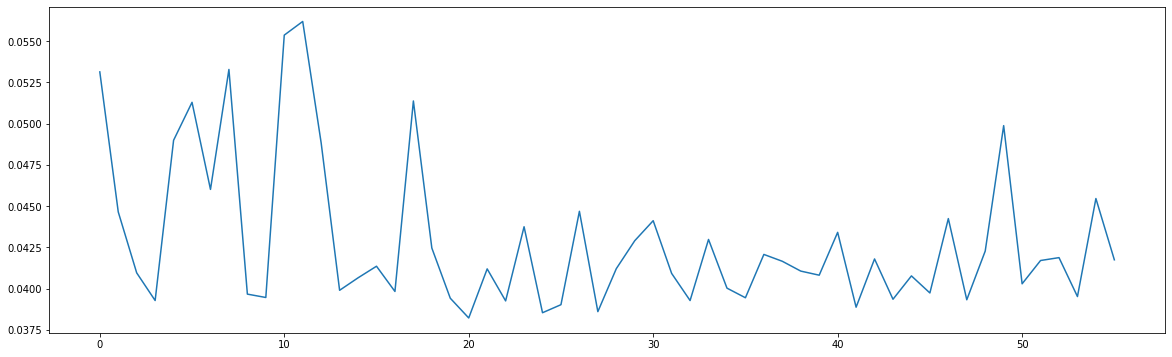

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize= (20,6))
plt.plot(linewidth=0.5)
plt.plot(RMSE)

In [ ]:
def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 0 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 0, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=5, batch_size=10, callbacks=[callback], verbose=0)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    RMSE_roulette.append(rmse)
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [ ]:
RMSE_roulette = []
creator.create('FitnessMin2', base.Fitness, weights = (-1.0,))
creator.create('Individual2', list , fitness = creator.FitnessMin2)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual2, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
#population = lista de individuos; cxpb probabilidad de aparear dos individuos; mutpb probabilidad de mutar un individuo;  ngen numero de generaciones; 
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1,
                        ngen = num_generations, verbose = False)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin2' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Window Size:  54 , Num of Units:  2
Validation RMSE:  0.057263550763427526 


Window Size:  50 , Num of Units:  5
Validation RMSE:  0.04061573487596642 


Window Size:  31 , Num of Units:  13
Validation RMSE:  0.04955846326650551 


Window Size:  33 , Num of Units:  4
Validation RMSE:  0.0418947246509162 


Window Size:  63 , Num of Units:  3
Validation RMSE:  0.04790561828716369 


Window Size:  27 , Num of Units:  2
Validation RMSE:  0.05486811229955553 


Window Size:  8 , Num of Units:  0

Window Size:  1 , Num of Units:  6
Validation RMSE:  0.058508971162687606 


Window Size:  63 , Num of Units:  2
Validation RMSE:  0.052459651986450674 


Window Size:  9 , Num of Units:  5
Validation RMSE:  0.04504293287134909 


Window Size:  62 , Num of Units:  2
Validation RMSE:  0.05139603214037659 


Window Size:  51 , Num of Units:  7
Validation RMSE:  0.04214649133346768 


Window Size:  29 , Num of Units:  11
Validation RMSE:  0.039896287417874515 


Window Size:  45 , Num of Units:  8


In [ ]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  63 , Num of Units:  15


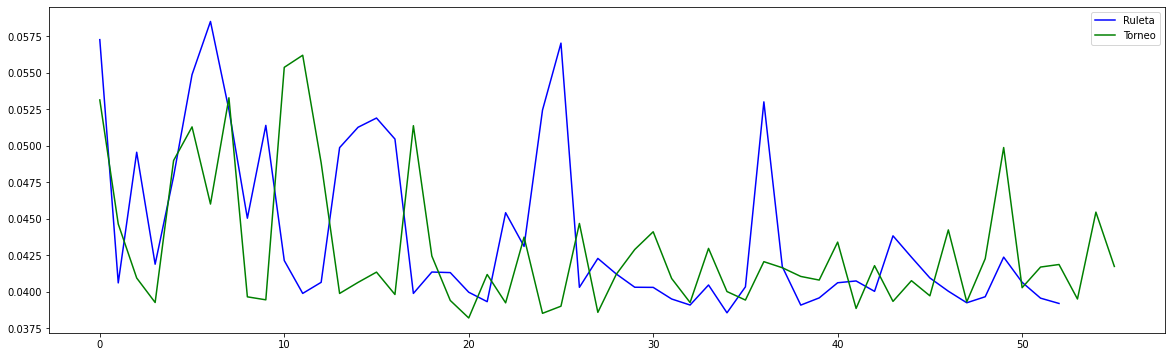

In [ ]:
plt.figure(figsize= (20,6))
plt.plot(linewidth=0.5)
plt.plot(RMSE_roulette, 'b', label="Ruleta")
plt.plot(RMSE, 'g', label="Torneo")
plt.legend()
plt.show()